In [1]:
# Data science task - pdf file
from IPython.display import IFrame
IFrame("Tractable_DS_Take_Home_Exercise (2) (1) (1).pdf",width=1000,height=1000)

In [2]:
# loading useful libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
%matplotlib inline

In [3]:
# reading the metadata. The metadata file is broken into severl files
# All the metadata file ends with extension ".gz" so we only read these files.
meta_filepath = './metadata/'
files = [file for file in os.listdir(meta_filepath) if file.endswith('.gz')] # creates a list of filenames
frames=[]
for file in files:
    frames.append(pd.read_csv(meta_filepath+file))
metadata = pd.concat(frames)

In [4]:
print(f"There are {metadata.shape[0]} rows and {metadata.shape[1]} columns in metadata")

There are 192066 rows and 10 columns in metadata


In [5]:
# checking if there are any dulicate files in metadata
metadata[metadata.duplicated()]

,claim_id,make,model,year,poi,line_num,part,operation,part_price,labour_amt


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192066 entries, 0 to 4800
Data columns (total 10 columns):
claim_id      192066 non-null int64
make          192066 non-null object
model         192066 non-null object
year          192066 non-null int64
poi           192066 non-null object
line_num      192066 non-null int64
part          192066 non-null object
operation     192066 non-null object
part_price    122068 non-null float64
labour_amt    192066 non-null float64
dtypes: float64(2), int64(3), object(5)
memory usage: 16.1+ MB


There are some null values in part_price column of metadata. Since we're not using it for the first part of the analysis we'll just ignore it for now.

The most important part of metadata that we need for optimising the decision boundary of our URR classifier is the ground truth values in **operation** column. We'll read the classifier_output.csv file and combine the ground truth to the correct claim id and part

In [7]:
# reading classifier output
clf_out = pd.read_csv('./classifier_output.csv')

In [8]:
clf_out.head()

,claim_id,part,urr_score,set
0,0,bbumper,0.1846,0
1,0,bldoor,0.1212,0
2,0,frdoor,0.0857,0
3,0,fldoor,0.0005,0
4,0,frwing,0.0666,0


In [9]:
print(f"There are {clf_out.shape[0]} rows and {clf_out.shape[1]} columns in classifier_output")
print("This corrsponds to 100000 claims with each claim having 10 outputs for 10 part of car being considered")

There are 1000000 rows and 4 columns in classifier_output
This corrsponds to 100000 claims with each claim having 10 outputs for 10 part of car being considered


claim_id =  unique id for a claim.

part = name of the part (there are 10 parts considered in this excercise)

urr_score = score of the undamaged-repair-replace classifier

set - identifier for train, val or test set

In [10]:
clf_out.groupby('set').size()

set
0    900790
1     50100
2     49110
dtype: int64

"Set" represents the training-validation-test split of approx. 90%-5%-5% where 0-training, 1-validation, 2-test. We'll first separate the clf_out to training, validation and test set so that we can validate(iterative process) our optimum decision boundary and then use that decision boundary to report the performance on test set(only once).

In [11]:
train_clf = clf_out[clf_out['set']==0]
val_clf = clf_out[clf_out['set']==1]
test_clf = clf_out[clf_out['set']==2]

In [12]:
train_clf.shape

(900790, 4)

Now we'll merge the **metadata** and **clf_out** dataframes. The unique identifier is the combination of 
**claim_id** and **part**. Since the metadata only contains information on **repair** and **replace** operaion,combining it with clf_out will lead to a lot of **NaN** values as clf_out has exactly 10 rows per **claim_id** i.e rows for even undamaged part which is not explicit in **metadata**. That's why I'm using a left outer join here. Therefore, we fill all the NaN values in **operation** column to **undamaged**. The remaining NaN values in other columns can be filled in by repeating the same value from one of the column for each claim but we'll ignore that at the moment as the other columns are not very useful for finding the optimum decision boundary from **urr_score**.

In [13]:
train_merged = train_clf.merge(metadata,on=['claim_id','part'],how='left')
train_merged['operation'].fillna('undamaged',inplace=True)

val_merged = val_clf.merge(metadata,on=['claim_id','part'],how='left')
val_merged['operation'].fillna('undamaged',inplace=True)

test_merged= test_clf.merge(metadata,on=['claim_id','part'],how='left')
test_merged['operation'].fillna('undamaged',inplace=True)

In [14]:
# 81% of the data in train,val and test set is unadamaged, 12% replace and 7% repair. Very imbalanced dataset

print("training set")
print(100*train_merged['operation'].value_counts()/train_merged.shape[0])

print("validation set")
print(100*val_merged['operation'].value_counts()/val_merged.shape[0])

print("test set")
print(100*test_merged['operation'].value_counts()/test_merged.shape[0])

training set
undamaged    80.801963
replace      12.304311
repair        6.893727
Name: operation, dtype: float64
validation set
undamaged    80.752495
replace      12.219561
repair        7.027944
Name: operation, dtype: float64
test set
undamaged    80.678070
replace      12.378334
repair        6.943596
Name: operation, dtype: float64


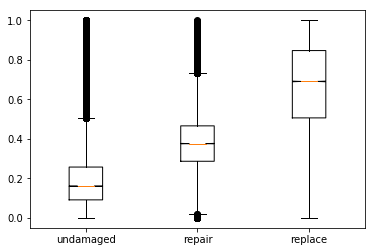

In [15]:
# creating a boxplot to compare the distribution of urr_score for each category i.e undamaged, repair, replace
plt.figure()
data_to_plot = [train_merged.loc[train_merged['operation']=='undamaged','urr_score'].dropna().values,
               train_merged.loc[train_merged['operation']=='repair','urr_score'].dropna().values,
               train_merged.loc[train_merged['operation']=='replace','urr_score'].dropna().values]
plt.boxplot(data_to_plot,notch=True);
plt.xticks([1,2,3],['undamaged','repair','replace']);

# we can see that the median 50% of the data for all categories is well separated but 
# some outliers are also present. We can visually see that the optimum boundaries might be around
# 0.3 and 0.5. Let's solve it and see if that's the case.

In [16]:
le = LabelEncoder()
train_merged['operation']=le.fit_transform(train_merged['operation'])
val_merged['operation']=le.transform(val_merged['operation'])
test_merged['operation']=le.transform(test_merged['operation'])

In [17]:
le.classes_

array(['repair', 'replace', 'undamaged'], dtype=object)

In [18]:
le.inverse_transform([0,0,1,1,2])

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['repair', 'repair', 'replace', 'replace', 'undamaged'],
      dtype=object)

In [19]:
train_merged['operation'].value_counts()

2    727856
1    110836
0     62098
Name: operation, dtype: int64

We see that the dataset is very imbalanced(as expected) as most parts are usually undamaged. It's highly unlikely for a car to be completely damaged from all sides unless ofcourse the accident is too severe like in movies sometimes :).
So we have to take this imbalance into account while defining our objective metric. 

Accuracy is definitely not a good metric here becuase of class imbalance.

Precision and recall seems like a good fit. It's not always a good idea to keep two different metrics for the performance evaluation of a single classifier as it can lead to some conflicts between two metrics therefore i'll choose F1-measure as a single numerical metric here which combines precision and recall.

There are 3 classes so we have to think about micro or macro f1-score. Macro calculates the precision and recall for each class and then takes it's average thus giving equal weightage to each class. This tells us how effective our model is on smaller classes(classes with low number of examples). therefore it seems like a good fit in our case.

Micro f1-score directly calculates the average statistics from the data i.e equal weightage to each example. Therefore, larger class can easily dominate here. This measures the effectiveness of model on larger class. 

Since our problem is of auto-insurance industry where we want to assess the **damage** therefore our focus should be slightly more on smaller classes therefore MACRO averaging is a better metric in this case.

Now we'll ignore the data points where the classifier_output is NaN i.e where the CNN wasn't able to recognise the part. Since this is a problem of the deep learning model rather than the URR-classifier.


There are two decision boundaries for classifying the 3 classes. The simplest approach is to use a nested loop to loop over all combinations of decision boundaries and choose the one with maximum F1-Score to be the optimal one.

In [20]:
#
i=0.0
train_scores = []
val_scores =[]
data = []
count=1
while i<1:
    j=0.99
    while j>i:
        train_merged.loc[train_merged['urr_score']<=i,'acc']=2
        train_merged.loc[(train_merged['urr_score']>i) & (train_merged['urr_score']<j) ,'acc']=0
        train_merged.loc[train_merged['urr_score']>=j,'acc']=1
        
        val_merged.loc[val_merged['urr_score']<=i,'acc']=2
        val_merged.loc[(val_merged['urr_score']>i) & (val_merged['urr_score']<j) ,'acc']=0
        val_merged.loc[val_merged['urr_score']>=j,'acc']=1
 
        t = train_merged[~np.isnan(train_merged['acc'])]
        train_scores.append(f1_score(t['operation'].values,t['acc'].values,average='macro'))


        v = val_merged[~np.isnan(val_merged['acc'])]
        val_scores.append(f1_score(v['operation'].values,v['acc'].values,average='macro'))
        
        data.append((i,j))
        j-=0.01
    i+=0.01    
    count+=1

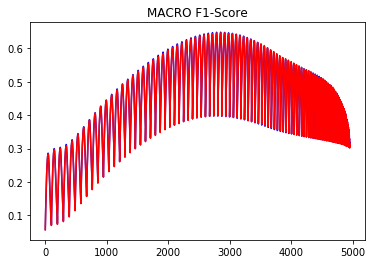

In [21]:
plt.title('MACRO F1-Score')
plt.plot(train_scores,c='blue')
plt.plot(val_scores,'red')

In [22]:
i,j = data[np.argmax(val_scores)]

test_merged.loc[test_merged['urr_score']<=i,'acc']=2
test_merged.loc[(test_merged['urr_score']>i) & (test_merged['urr_score']<j) ,'acc']=0
test_merged.loc[test_merged['urr_score']>=j,'acc']=1

te = test_merged[~np.isnan(test_merged['acc'])] # removing the rows where classifier_output is NaN
f1_score(te['operation'].values,te['acc'].values,average='micro')

0.8140532645655993

In [23]:
confusion_matrix(te['operation'],te['acc'])

array([[ 1465,   452,  1388],
       [ 1190,  4327,   480],
       [ 3323,  1315, 29879]])

In [24]:
print('macro')
print(confusion_matrix(te['operation'],te['acc'])/np.sum(confusion_matrix(te['operation'],te['acc']),axis=0))

macro
[[0.24506524 0.07417132 0.04372067]
 [0.19906323 0.71004266 0.01511954]
 [0.55587153 0.21578602 0.94115979]]


In [26]:
print(f'The decision boundaries are {i} and {j}')

The decision boundaries are 0.35000000000000014 and 0.5299999999999996


# Discuss ways you would scale your code to ingest more data, i.e. of the order of millions. Also,  discuss ways you would further improve the performance of the classifiers if you had more time.

1. Better algorithmic design as right now the complexity of my code is O(n^2). We might be able to turn this into O(n) or O(nlog(n)) by using clever implentation of the same problem where we only iterate over the significant values of decision boundaries.
2. Use Big data tools.
3. Parallel computing.
4. Maybe build a different decision boundary for each part? This might improve the performance of the classifiers.
5. I'd like to know the inner workings of URR_classifier and try to improve it. Given the opportunity to build the URR-classifier from scratch, I'd like to try a 3-d one hot encoded output for repair, replace and undamaged category. This will give us the probability of each part and might result is a bit better performance. I think, this is worth trying.

# Bonus Task - Predict cost of performing the operation

The cost of replacing or repairing a part of any car depends on the car model, the amount of damage and the labour charges e.g the parts of rolls royce phantom are much more expensive than parts of kia Rio5 etc. So for replacing a part the car model is the most important feature but for repairing the car the amount of damage and labour charges are important too.

The task at hand is to build a regression model to determine the part_price and labour amount. 

The part_price can be directly found from a lookup table which has car model as the keys. We don't need to build a machine learning model for that. We can also use the data which shows whether the added part is a new one or a used one. The new part is the maximum price and if it's a used one it'll be a bit less expensive. If we have this data we can just lookup the price from the database.

The labour_amt depends on the amount of damage, the particular part and labour charges of the bodyshop. I think we don't need to build a machine learning model for this task either as it can simply be a lookup table. 

**Solution** - 
Build a database with information on repalcement parts of different car models as well as labour charges of the bodyshop for different parts of the car. This database can be created by web scraping car model vs parts price data. The bodyshop is going to contact the insurance company with the images of the damaged car so we can get the labour charges for different parts of the car from that bodyshop for that particular case and update our database as new cases come in.


